# Time Series Prediction using Recurrent Neural Network (RNN) in PyTorch

##  Objective
To train and evaluate a Recurrent Neural Network (RNN) using PyTorch to predict the next value in the International Airline Passengers time series dataset.


## Model Description

### Dataset:
- The dataset used is the International Airline Passengers dataset.
- It records monthly airline passenger totals from Jan 1949 to Dec 1960.

### Model Architecture:
- A simple RNN-based model is used.
- Input and output size: 1
- Hidden layer size: 32
- Recurrent layer: 1
- Output layer: Fully connected (Linear)

### Training Details:
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam
- Learning rate: 0.01
- Epochs: 100


Epoch [10/100], Loss: 0.031115, Accuracy: 75.11%
Epoch [20/100], Loss: 0.014810, Accuracy: 84.68%
Epoch [30/100], Loss: 0.006303, Accuracy: 89.23%
Epoch [40/100], Loss: 0.004825, Accuracy: 90.36%
Epoch [50/100], Loss: 0.003463, Accuracy: 91.76%
Epoch [60/100], Loss: 0.003327, Accuracy: 91.75%
Epoch [70/100], Loss: 0.003127, Accuracy: 92.00%
Epoch [80/100], Loss: 0.002933, Accuracy: 92.35%
Epoch [90/100], Loss: 0.002840, Accuracy: 92.46%
Epoch [100/100], Loss: 0.002759, Accuracy: 92.52%

Final MSE Loss: 737.9654
Final Custom Accuracy: 92.56%


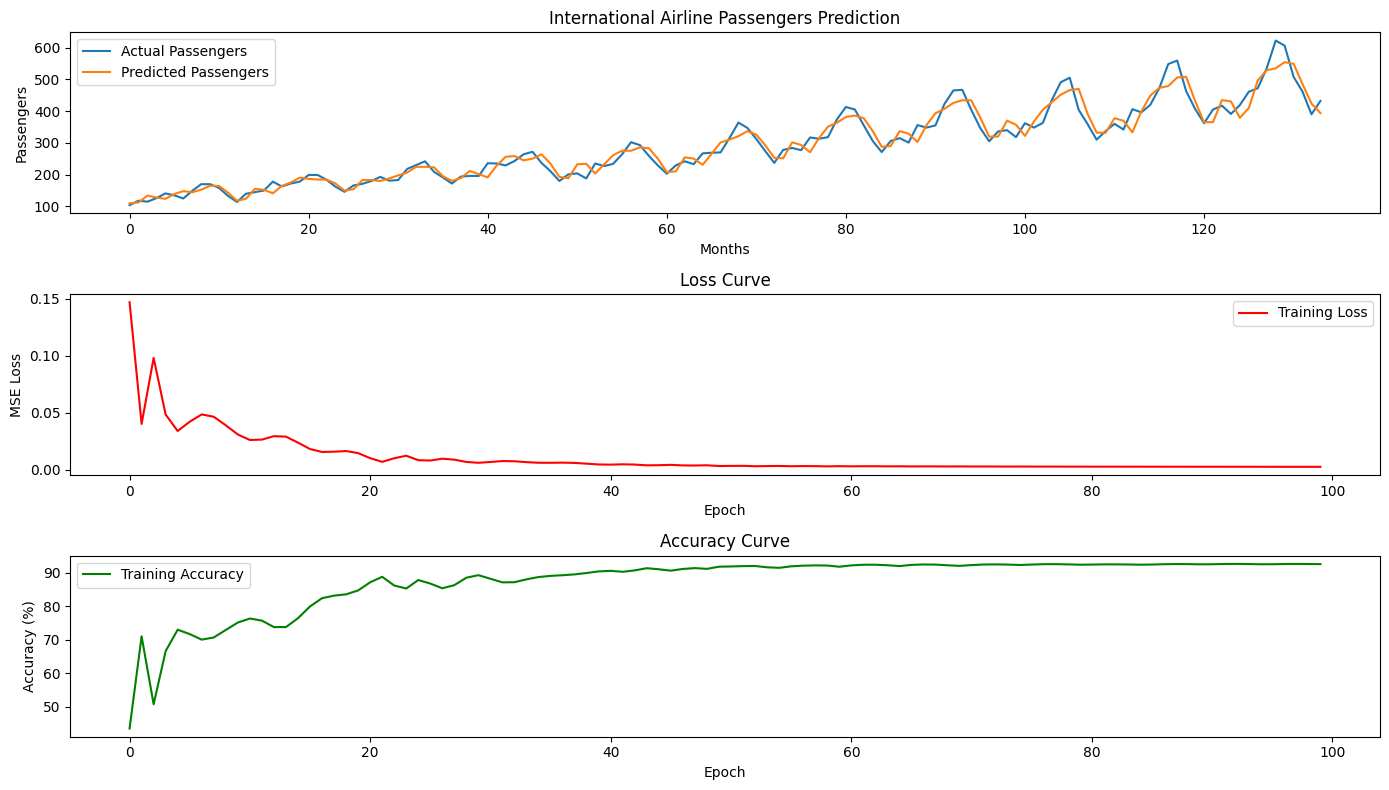

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Load the dataset
url = 'airline-passengers.csv'
data = pd.read_csv(url)

# Only 'Passengers' column needed
passengers = data['Passengers'].values.astype(float)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
passengers = scaler.fit_transform(passengers.reshape(-1, 1))

# 2. Create sequences
def create_dataset(series, seq_length):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_dataset(passengers, seq_length)

# Convert to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
X = X.view(X.size(0), seq_length, 1)

# 3. Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Model setup
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. Train the model
num_epochs = 100
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y.squeeze())
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Calculate custom accuracy
    predicted = outputs.detach().numpy()
    actual = y.detach().numpy()

    predicted = scaler.inverse_transform(predicted)
    actual = scaler.inverse_transform(actual)

    mae = np.mean(np.abs(predicted.flatten() - actual.flatten()))
    mean_actual = np.mean(actual.flatten())
    accuracy = 1 - (mae / mean_actual)

    accuracies.append(accuracy * 100)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Accuracy: {accuracy*100:.2f}%')

# 5. Final Evaluation
model.eval()
predicted = model(X).detach().numpy()
actual = y.detach().numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

final_loss = np.mean((predicted.flatten() - actual.flatten())**2)
final_mae = np.mean(np.abs(predicted.flatten() - actual.flatten()))
final_mean_actual = np.mean(actual.flatten())
final_accuracy = 1 - (final_mae / final_mean_actual)

print(f"\nFinal MSE Loss: {final_loss:.4f}")
print(f"Final Custom Accuracy: {final_accuracy*100:.2f}%")

# 6. Plot everything
plt.figure(figsize=(14,8))

# Plot Predictions
plt.subplot(3,1,1)
plt.plot(actual, label='Actual Passengers')
plt.plot(predicted, label='Predicted Passengers')
plt.title('International Airline Passengers Prediction')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.legend()

# Plot Loss Curve
plt.subplot(3,1,2)
plt.plot(losses, label='Training Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(3,1,3)
plt.plot(accuracies, label='Training Accuracy', color='green')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

##  My Comments
- The batch size is not defined; the entire dataset is used due to its small size.
- A plain RNN is used, which works well for small datasets. For larger datasets, LSTM is recommended due to vanishing gradient issues.
- Surprisingly, LSTM performs slightly worse here due to the simplicity of the dataset and lack of long-term dependencies.
